# Evaluating KSS performance

Question

## 1. Importing necessary libraries 

In [65]:
from typing import TextIO, List, Union, Dict, Tuple
import doctest
from sentiment import *
from random import shuffle
import csv
import sys
import math

import pandas as pd
import matplotlib.pyplot as plt

## 2. Partitioning data into Test and training data

This function partitions randomly the given dataset into test and training data. the argument test_size is used to determined the size of the test dataset e.g., 0.2 = 20% of the dataset. 

In [66]:
def partition_dataset(file:TextIO, file_name:str, test_size:float) -> Dict:
    """Precondition: test_size > 0.0 and < 1.0 (one decimal)
    Create two datasets sorted randomly from the original. The test_dataset has the size
    requested in test_size, and the trainin_dataset has the remaining size.
    Print a message e.g., "The files: test_data.txt and training_data.txt were created",
    and return a dictionary e.g., {'test': 'test_data.txt', 'training': 'training_data.txt'}
    
    >>> file_names = partition_dataset(open('full.txt', 'r'), 'data', 0.2)
    The files: test_data.txt and training_data.txt were created
    >>> file_names
    {'test': 'test_data.txt', 'training': 'training_data.txt'}
    """
    all_reviews = file.readlines()
    shuffle(all_reviews)
    rating_counts = {}
    test_reviews = []
    training_reviews = []
    for review in all_reviews:
        if review[0] in rating_counts:
            rating_counts[review[0]].append(review)
        else:
            rating_counts[review[0]] = [review]
    #print(rating_counts['4'])
    for rating, reviews in rating_counts.items():
        #print(rating, values)
        length_of_test_data = round(len(reviews) * (test_size))
        test_reviews.extend(reviews[:length_of_test_data])
        training_reviews.extend(reviews[length_of_test_data:])
    test_file_name = "test_" + file_name + ".txt"
    training_file_name = "training_" + file_name + ".txt"

    with open(test_file_name, 'w') as test_file:
        for row in test_reviews:
            test_file.write(row)

    with open(training_file_name, 'w') as training_file:
        for row in training_reviews: 
            training_file.write(row)

    print('The files: '+ test_file_name + ' and ' + training_file_name + ' were created')
    return {'test':test_file_name, 'training':training_file_name}

## 3. Training the model


This function tests whether or not the accuracy of the model is significant. To do that, the **testing_pss** function calculates the Mean_Absolute_Error(MAE) with kss as the resource for training the model. Moreover, this function creates a new version of kss removing all common words coming from **most_common_english_words.txt** file.

In [67]:
def testing_pss(test_file:TextIO, common_words_file:TextIO ,kss: Dict[str, List[int]], name_datasets) -> Dict:
    """Create a csv dataset with the comparison of the scores given by the kss model and the original ones. Print 
    the message "The file: reviews_comparison.csv was created" and return a dictionary with the Mean_Absolute_Error(MAE) 
    and Mean_Absolute_Error(MAE)_Sharpened of the dataset e.g., 
    {'Mean_Absolute_Error(MAE)': 1.00225, 'Mean_Absolute_Error(MAE)_Sharpened': 0.96186}
    
    >>> file1 = open('full.txt', 'r')
    
    >>> file2 = open('most_common_english_words.txt', 'r')
    
    >>> testing_result = testing_pss(file1, file2, kss, 'data')
    The file: reviews_data.csv was created
    >>> file1.close()
    
    >>> file2.close()
    
    """
    common_words_file = common_words_file.read().splitlines()
    review_scores = []
    absolute_errors = []
    test_reviews = test_file.readlines()
    
    #sharpened variables
    kss_sharpened = {}
    absolute_errors_sharpened = []
    sum_of_frequencies = 0
    
    ### remove all common words
    for word, value in kss.items():
        if word not in common_words_file:
            kss_sharpened[word] = value
            sum_of_frequencies += value[1]
    
       
    #Iterate over each review in order to get predicted rating and MAE for kss and the sharpened version of kss          
    for review in test_reviews:
        statement = review[1:].strip()
        original_rating = float(review[0])
        
        #Calculate predicted rating
        predicted_rating = statement_pss(review, kss)
        if predicted_rating != None:
            is_close_val = math.isclose(predicted_rating, original_rating, abs_tol=0.05)
            absolute_error = round((abs(float(predicted_rating) - original_rating)), 2)
            absolute_errors.append(absolute_error)
            mean_absolute_error = round(sum(absolute_errors)/len(absolute_errors), 5)
            
        
        #Sharp and calculate predicted rating
        predicted_rating_sharpened = statement_pss(review, kss_sharpened)
        if predicted_rating_sharpened != None:
            is_close_val_sharpened = math.isclose(predicted_rating_sharpened, original_rating, abs_tol=0.05)
            absolute_error_sharpened = round((abs(float(predicted_rating_sharpened) - original_rating)), 2)
            absolute_errors_sharpened.append(absolute_error_sharpened)
            mean_absolute_error_sharpened = round(sum(absolute_errors_sharpened)/len(absolute_errors_sharpened), 5)
            
        #Append predicted and sharpened values in the same list 
        if predicted_rating != None and predicted_rating_sharpened != None:
            review_scores.append([statement, original_rating, round(predicted_rating, 2), round(predicted_rating), 
                                  absolute_error,is_close_val, round(predicted_rating_sharpened, 2), 
                                  round(predicted_rating_sharpened), absolute_error_sharpened, is_close_val_sharpened])

    #Save all reviews with their predicted scores and MAE using kss and kss_sharpened     
    with open('reviews_'+ name_datasets + '.csv', mode ='w') as comparison_file:
        comparison_writer = csv.writer(comparison_file, delimiter=",", quotechar='"', quoting = csv.QUOTE_MINIMAL)
        comparison_writer.writerow(["Mean Absolute Error(MAE): " + str(mean_absolute_error) ])
        comparison_writer.writerow(["Mean Absolute Error(MAE) Sharpened: " + str(mean_absolute_error_sharpened) ])
        comparison_writer.writerow(["-","-","-","-","-"])
        comparison_writer.writerow(["Review", "Original Rating", "PSS Score", "Predicted Rating", "Absolute Error", 
                                    "Evaluation Result", "PSS Score Sharpened", "Predicted Rating Sharpened",
                                    "Absolute Error Sharpened", "Evaluation Result Sharpened"])
        for row in review_scores:
            comparison_writer.writerow(row)

    print('The file: ' + 'reviews_'+ name_datasets + '.csv' + ' was created')
    return {"Mean_Absolute_Error(MAE)": mean_absolute_error,"Mean_Absolute_Error(MAE)_Sharpened":mean_absolute_error_sharpened}

This function runs the test for more than one dataset and returns the MAE and the MAE_sharpened for each dataset as a dictionary

In [68]:
def execute_test(datasets: Dict[str, str], partition_size):
    """Precondition: the dictionary should have the form {name_dataset:dataset} e.g., {"small":"small.txt","medium":"medium.txt","full":"full.txt"}  
    
    Run testing_pss function for various datasets.
    """
    for name in datasets:
        with open(datasets[name], 'r') as file:
            file_names = partition_dataset(file, name, partition_size)
        with open(file_names['training'], 'r') as training_file:
                kss = extract_kss(training_file)  
        with open(file_names['test'], 'r') as test:
            with open(most_common_words) as common_words_file:
                testing_result = testing_pss(test, common_words_file, kss, name)
        print(testing_result)

## 4. Testing the model


This code allows to assess the functions created and the KSS model

In [69]:
if __name__ == "__main__":
    
    #Create a dictionary containing diferent datasets, in order to compare accuracies among each other.
    datasets =  {
        "small"     : "small.txt",
        "medium"    : "medium.txt",
        "full"      : "full.txt"
    }        
    
    most_common_words = "most_common_english_words.txt"
    #most_common_words = "stoplist.txt"
    
    #Test for the function execute_test 
    execute_test(datasets, 0.1)

    # Pick a dataset  
    # dataset = 'tiny.txt'
    # dataset = 'small.txt'
    #dataset = 'medium.txt'
    dataset = 'full.txt'

     # Test if the training and test datasets were created
    name_datasets = 'data'
     
    with open(dataset, 'r') as file:
        file_names = partition_dataset(file, name_datasets, 0.2)

 

    # Training the model with the training dataset created
    with open(file_names['training'], 'r') as training_file:
        kss = extract_kss(training_file)


    # Testing the results with the test dataset created
    with open(file_names['test'], 'r') as test_file:
        with open("most_common_english_words.txt") as common_words_file:
            testing_result = testing_pss(test_file, common_words_file, kss, name_datasets)
    print(testing_result)
   
    # Use test mode

    doctest.testmod()

The files: test_small.txt and training_small.txt were created
The file: reviews_small.csv was created
{'Mean_Absolute_Error(MAE)': 1.08, 'Mean_Absolute_Error(MAE)_Sharpened': 0.69}
The files: test_medium.txt and training_medium.txt were created
The file: reviews_medium.csv was created
{'Mean_Absolute_Error(MAE)': 1.10255, 'Mean_Absolute_Error(MAE)_Sharpened': 1.13071}
The files: test_full.txt and training_full.txt were created
The file: reviews_full.csv was created
{'Mean_Absolute_Error(MAE)': 0.98154, 'Mean_Absolute_Error(MAE)_Sharpened': 0.94161}
The files: test_data.txt and training_data.txt were created
The file: reviews_data.csv was created
{'Mean_Absolute_Error(MAE)': 0.99964, 'Mean_Absolute_Error(MAE)_Sharpened': 0.9618}


## 5. Analysing the results

Before the analysis, we need to import our result datasets

In [70]:
evaluated_reviews_full = pd.read_csv('reviews_full.csv', header=3)
evaluated_reviews_full.head()

,Review,Original Rating,PSS Score,Predicted Rating,Absolute Error,Evaluation Result,PSS Score Sharpened,Predicted Rating Sharpened,Absolute Error Sharpened,Evaluation Result Sharpened
0,A gangster movie with the capacity to surprise .,3.0,2.13,2,0.87,False,2.64,3,0.36,False
1,"For those in search of something different , W...",3.0,2.22,2,0.78,False,2.15,2,0.85,False
2,While the now 72-year-old Robert Evans been sl...,3.0,2.10,2,0.90,False,2.16,2,0.84,False
3,For a long time the film succeeds with its dar...,3.0,2.17,2,0.83,False,2.28,2,0.72,False
4,"The real triumphs in Igby come from Philippe ,...",3.0,2.16,2,0.84,False,2.56,3,0.44,False


In [71]:
evaluated_reviews_medium = pd.read_csv('reviews_medium.csv', header=3)
evaluated_reviews_medium.head()

,Review,Original Rating,PSS Score,Predicted Rating,Absolute Error,Evaluation Result,PSS Score Sharpened,Predicted Rating Sharpened,Absolute Error Sharpened,Evaluation Result Sharpened
0,Two badly interlocked stories drowned by all t...,1.0,1.80,2,0.80,False,2.17,2,1.17,False
1,A fake street drama that keeps telling you thi...,1.0,1.88,2,0.88,False,1.50,2,0.50,False
2,Even in terms of the low-grade cheese standard...,1.0,2.10,2,1.10,False,2.00,2,1.00,False
3,... its solemn pretension prevents us from sha...,1.0,2.04,2,1.04,False,2.75,3,1.75,False
4,Since Dahmer resorts to standard slasher flick...,1.0,2.01,2,1.01,False,2.50,2,1.50,False


In [72]:
evaluated_reviews_small = pd.read_csv('reviews_small.csv', header=3)
evaluated_reviews_small.head()

,Review,Original Rating,PSS Score,Predicted Rating,Absolute Error,Evaluation Result,PSS Score Sharpened,Predicted Rating Sharpened,Absolute Error Sharpened,Evaluation Result Sharpened
0,"Has a certain ghoulish fascination , and gener...",3.0,2.10,2,0.90,False,2.12,2,0.88,False
1,With its parade of almost perpetually wasted c...,1.0,2.26,2,1.26,False,1.50,2,0.50,False


Now, we need to plot a histogram which is a good tool to interpret the distribution of the reviews.

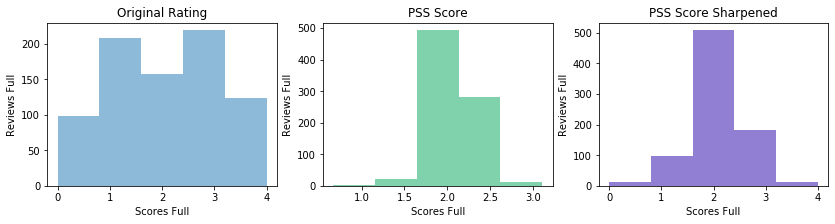

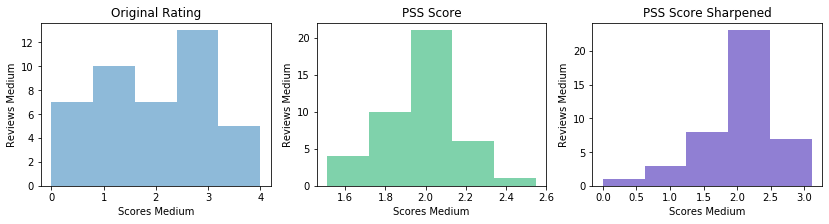

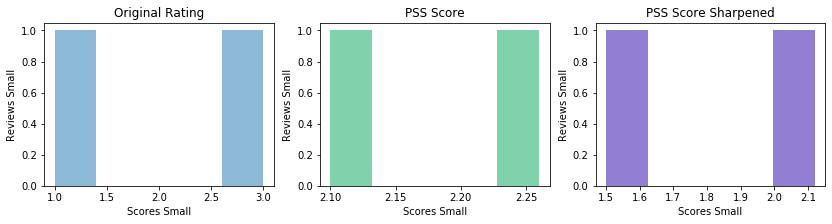

In [83]:
#Distributions for Full dataset
plots_size = (14,3)
plt.figure(1, figsize=plots_size)
#Subplot 1
original = plt.subplot(131)
original.hist(evaluated_reviews_full['Original Rating'], bins=5, alpha=0.5, label='PSS')
original.set_title('Original Rating')
original.set_xlabel('Scores Full')
original.set_ylabel('Reviews Full')
#Subplot 2
predicted = plt.subplot(132)
predicted.hist(evaluated_reviews_full['PSS Score'], bins=5, alpha=0.5, label='PSS', color='#00A658')
predicted.set_title('PSS Score')
predicted.set_xlabel('Scores Full')
predicted.set_ylabel('Reviews Full')
#Subplot 3
predicted_sharpen = plt.subplot(133)
predicted_sharpen.hist(evaluated_reviews_full['PSS Score Sharpened'], bins=5, alpha=0.5, label='PSS Sharpen', color='#2300A8')
predicted_sharpen.set_title('PSS Score Sharpened')
predicted_sharpen.set_xlabel('Scores Full')
predicted_sharpen.set_ylabel('Reviews Full')

#Distributions for Medium dataset
plots_size = (14,3)
plt.figure(2, figsize=plots_size)
#Subplot 1
original = plt.subplot(131)
original.hist(evaluated_reviews_medium['Original Rating'], bins=5, alpha=0.5, label='PSS')
original.set_title('Original Rating')
original.set_xlabel('Scores Medium')
original.set_ylabel('Reviews Medium')
#Subplot 2
predicted = plt.subplot(132)
predicted.hist(evaluated_reviews_medium['PSS Score'], bins=5, alpha=0.5, label='PSS', color='#00A658')
predicted.set_title('PSS Score')
predicted.set_xlabel('Scores Medium')
predicted.set_ylabel('Reviews Medium')
#Subplot 3
predicted_sharpen = plt.subplot(133)
predicted_sharpen.hist(evaluated_reviews_medium['PSS Score Sharpened'], bins=5, alpha=0.5, label='PSS Sharpen', color='#2300A8')
predicted_sharpen.set_title('PSS Score Sharpened')
predicted_sharpen.set_xlabel('Scores Medium')
predicted_sharpen.set_ylabel('Reviews Medium')

#Distributions for Small dataset
plots_size = (14,3)
plt.figure(3, figsize=plots_size)
#Subplot 1
original = plt.subplot(131)
original.hist(evaluated_reviews_small['Original Rating'], bins=5, alpha=0.5, label='PSS')
original.set_title('Original Rating')
original.set_xlabel('Scores Small')
original.set_ylabel('Reviews Small')
#Subplot 2
predicted = plt.subplot(132)
predicted.hist(evaluated_reviews_small['PSS Score'], bins=5, alpha=0.5, label='PSS', color='#00A658')
predicted.set_title('PSS Score')
predicted.set_xlabel('Scores Small')
predicted.set_ylabel('Reviews Small')
#Subplot 3
predicted_sharpen = plt.subplot(133)
predicted_sharpen.hist(evaluated_reviews_small['PSS Score Sharpened'], bins=5, alpha=0.5, label='PSS Sharpen', color='#2300A8')
predicted_sharpen.set_title('PSS Score Sharpened')
predicted_sharpen.set_xlabel('Scores Small')
predicted_sharpen.set_ylabel('Reviews Small')

plt.show()